<a href="https://colab.research.google.com/github/yangzongru-jpg/ZSCL_copy/blob/main/contrib/colab/DC-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>  &nbsp;&nbsp;Training DC-GAN using Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [5]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 899.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

### If you're using GPU with this colab notebook, run the below commented code to install GPU compatible PyTorch wheel and dependencies

In [4]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall

ERROR: torch_xla-2.0-cp39-cp39-linux_x86_64.whl is not a supported wheel on this platform.


### Only run the below commented cell if you would like a nightly release

In [ ]:
# VERSION = "1.13"  #@param ["1.13", "nightly", "20220315"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

## Generative Adersarial Networks (GANs)

In the landmark paper [Goodfellow et al.](https://arxiv.org/abs/1406.2661) , published in 2014, authors introduced this novel paradigm for generative models. The fundamental idea proposed in the work is to train a Generator Network in adversarial setup, where a discriminator network downstream critiques the generated samples.

Simply put, generator network generates a sample and discriminator network classifies it as a real or fake. Discriminator is also provided with real samples. The objective functions takes the following form:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where: <br>
$x \sim p_\text{data}$ are samples from the input data.
$z \sim p(z)$ are the random noise samples.
$G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real.

## Training Setup

This example illustrates distributed (data parallel) training of DC-GAN model using MNIST dataset on a TPU device. A TPU device consistes of 4 chips (8 cores; 2 cores/chip). Both the discriminator and generator replica are created on each of 8 cores. The dataset is splitted across the 8 cores.
<br> At every training step, each of the cores perfoms the forward (loss computation) and backward (gradient computation) on the given minibatch and then [all_reduce](https://www.tensorflow.org/xla/operation_semantics#allreduce) is performed across TPU cores to update the parameters. Notice `xm.optimizer_step` call in the discriminator and optimizer train steps.

General GAN training looks like:

1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

We will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to alleviate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

Therefore the training loop in this notebook will entail:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [6]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu

# Setting up the Global Flags

In the current setup, Discriminator network was chosen to be a smaller capacity than generator. Even with similar capacity networks, generator update path is deeper than discriminator. Therefore uneven learning rates chosen here seems to yield a better convergence.


In [7]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['gen_learning_rate'] = 0.005
FLAGS['disc_learning_rate'] = 0.001
FLAGS['num_epochs'] = 21
FLAGS['num_cores'] = 8

In [8]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython import display

from google.colab.patches import cv2_imshow
import cv2

RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(*images):
    num_images = len(images)
    n_rows = 4
    n_columns =len(images) // n_rows
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(11, 9))

    for i, ax in enumerate(fig.axes):
        ax.axis('off')
        if i >= num_images:
          continue
        img = images[i]
        img = img.squeeze() # [1,Y,X] -> [Y,X]
        ax.imshow(img)
    plt.savefig(RESULT_IMG_PATH, transparent=True)

def display_results():
    img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)

In [9]:
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(FLAGS['datadir'])
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [10]:
class DiscriminativeNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4*4*64, 1)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), 0.01)
        x = self.bn1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2), 0.01)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), 0.01)
        return torch.sigmoid(x)


In [11]:
class GenerativeNet(torch.nn.Module):

    def __init__(self):
        super(GenerativeNet, self).__init__()
        self.input_size = 100
        self.linear1 = nn.Linear(self.input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 7*7*128)
        self.bn2 = nn.BatchNorm1d(7*7*128)
        self.conv1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        )

    # Noise
    def generate_noise(self, size):
        n = torch.randn(size, self.input_size)
        return n

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        return x

In [12]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [13]:
def real_data_target(size, device):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size, device):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

# Note on the use of .detach() method

You will notice in the following code snippet that when the generator is used to create the `fake_data`, .detach() for the discriminator training step, the .detach call is used to create a new view of the fake_data tensor for which the operations will not be recorded for gradient computation.<br>

Since fake_date is an output of an nn.module, by default, pytorch will record all the operations performed on this tensor during the forward pass as DAG. And after the backward pass these DAG and corresponding operations are cleared (unless `retain_graph=True`).
Therefore such a tensor can be part of only one cone of logic where the forward and backward pass is done. If there are two loss function where this tensor is used and backward pass is performed on these two function (or even sum of the functions) for the second backward pass the operations DAG will not be found, leading to an error.

The second place, where detach() is used is when a numpy() call is to be made to tensor (for plotting purposes). Pytorch also requires that requires_grad should not be true on these tensor. (Ref: `
RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.`)

In [16]:
SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.
generator = GenerativeNet()
generator.apply(init_weights)
descriminator = DiscriminativeNet()
descriminator.apply(init_weights)
WRAPPED_GENERATOR = xmp.MpModelWrapper(generator)
WRAPPED_DISCRIMINATOR = xmp.MpModelWrapper(descriminator)

def train_gan(rank):
    torch.manual_seed(1)
    data = SERIAL_EXEC.run(lambda: mnist_data())
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        data,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True)


    # Create loader with data, so that we can iterate over it
    train_loader = torch.utils.data.DataLoader(
      data,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

    # Num batches
    num_batches = len(train_loader)

    device = xm.xla_device()

    generator = WRAPPED_GENERATOR.to(device)
    discriminator = WRAPPED_DISCRIMINATOR.to(device)


    # Optimizers
    d_optimizer = Adam(discriminator.parameters(), lr=FLAGS['disc_learning_rate'], betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=FLAGS['gen_learning_rate'], betas=(0.5, 0.999))

    # Number of epochs
    num_epochs = FLAGS['num_epochs']
    # Loss function
    loss = nn.BCELoss()


    def train_step_discriminator(optimizer, real_data, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()

        # 1. Train on Real Data
        prediction_real = discriminator(real_data)
        # Calculate error and backpropagate
        error_real = loss(prediction_real, real_data_target(real_data.size(0), device))


        # 2. Train on Fake Data
        prediction_fake = discriminator(fake_data)
        # Calculate error and backpropagate

        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
        total_error = error_real + error_fake
        total_error.backward()

        # Update weights with gradients
        xm.optimizer_step(optimizer)

        return total_error, prediction_real, prediction_fake

    def train_step_generator(optimizer, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()
        prediction = discriminator(fake_data)
        # Calculate error and backpropagate
        error = loss(prediction, real_data_target(prediction.size(0), device))
        error.backward()
        # Update weights with gradients
        xm.optimizer_step(optimizer)

        # Return error
        return error

    # Notice the use of .detach() when fake_data is to passed into discriminator
    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        for n_batch, (real_batch,_) in enumerate(loader):
            # Train Step Descriminator
            real_data = real_batch.to(device)
            # sample noise and generate fake data
            noise = generator.generate_noise(real_data.size(0)).to(device)
            fake_data = generator(noise)
            d_error, d_pred_real, d_pred_fake = train_step_discriminator(
                d_optimizer, real_data, fake_data.detach(), device)

            #Train Step Generator
            noise = generator.generate_noise(real_data.size(0)).to(device)
            fake_data = generator(noise)
            g_error = train_step_generator(g_optimizer, fake_data, device)
        return d_error.item(), g_error.item()


    for epoch in range(1, FLAGS['num_epochs'] + 1):
        d_error, g_error = train_loop_fn (pl.MpDeviceLoader(train_loader, device))
        xm.master_print("Finished training epoch {}: D_error:{}, G_error: {}".format(epoch, d_error, g_error))

    num_test_samples = 24
    test_noise = generator.generate_noise(num_test_samples).to(device)
    xm.do_on_ordinals(plot_results, generator(test_noise).detach(), (0,))

In [15]:
# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_gan(rank)

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

100%|██████████| 9912422/9912422 [00:00<00:00, 90609884.52it/s]


Extracting /tmp/mnist/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71635537.45it/s]


Extracting /tmp/mnist/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25831010.39it/s]


Extracting /tmp/mnist/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16979080.90it/s]


Extracting /tmp/mnist/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/dataset/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

Finished training epoch 1: D_error:1.3207664489746094, G_error: 0.6771314144134521
Finished training epoch 2: D_error:1.2946991920471191, G_error: 0.6438493132591248
Finished training epoch 3: D_error:1.297753930091858, G_error: 0.6893309354782104
Finished training epoch 4: D_error:1.3286539316177368, G_error: 0.6829544901847839
Finished training epoch 5: D_error:1.2386399507522583, G_error: 0.6234535574913025
Finished training epoch 6: D_error:1.2127379179000854, G_error: 0.6887510418891907
Finished training epoch 7: D_error:1.1831963062286377, G_error: 0.6253861784934998
Finished training epoch 8: D_error:1.1579914093017578, G_error: 0.6775871515274048
Finished training epoch 9: D_error:1.0803654193878174, G_error: 0.65578693151474
Finished training epoch 10: D_error:1.0873016119003296, G_error: 0.6241307854652405
Finished training epoch 11: D_error:1.141200304031372, G_error: 0.6688144207000732
Finished training epoch 12: D_error:1.0859349966049194, G_error: 0.6271856427192688
Finis

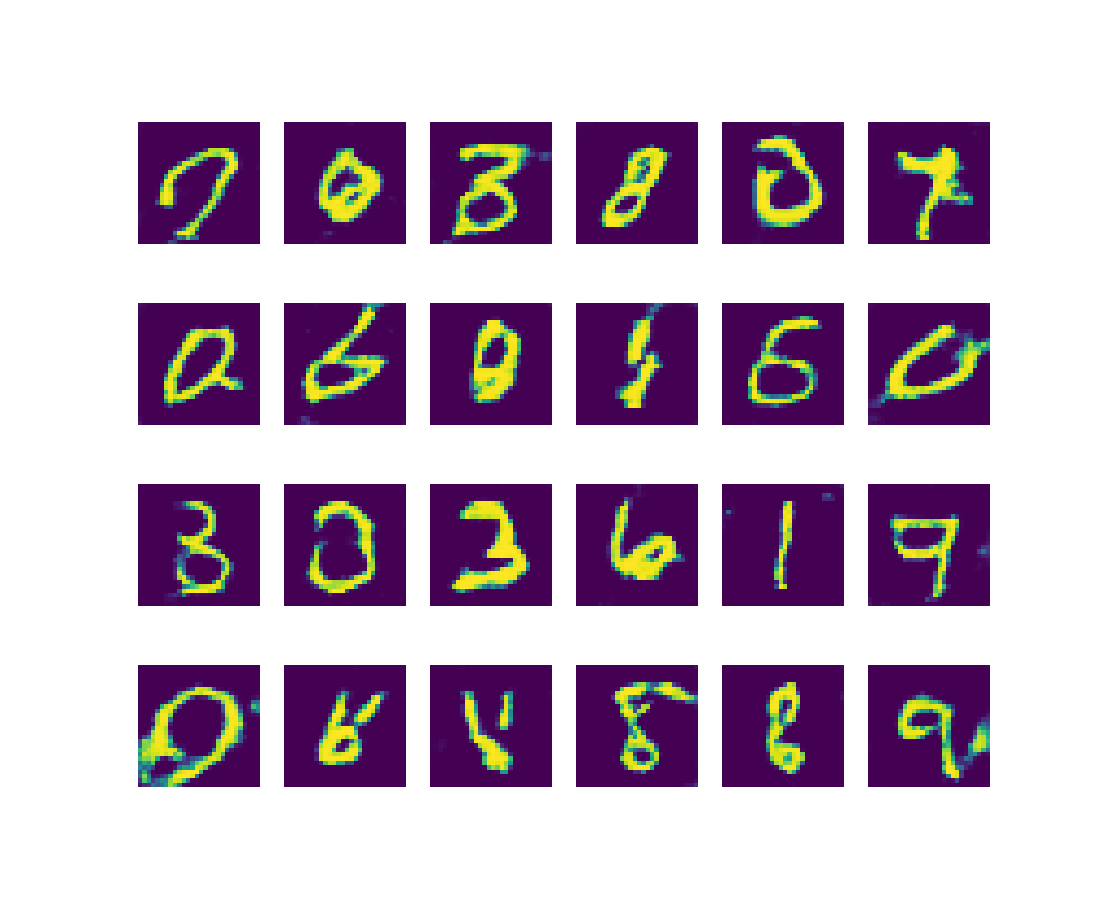

In [17]:
display_results()

## References:
[Training GAN from Scratch] (https://github.com/diegoalejogm/gans) <br>
[CS231n] (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf)